In [1090]:
import tensorflow as tf
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.utils import resample
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
import matplotlib.pyplot as plt


In [1199]:
np.random.seed(1)

In [1062]:
df = pd.read_csv('bank.csv')

In [1063]:
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [1064]:
df = df[df.columns[3:]] #getting rid of the RowNumber, ID, and Surname as these do not have anything to do with the banking

In [1065]:
df.info() #there don't seem be any null values and the Dtypes match what they should be.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CreditScore      10000 non-null  int64  
 1   Geography        10000 non-null  object 
 2   Gender           10000 non-null  object 
 3   Age              10000 non-null  int64  
 4   Tenure           10000 non-null  int64  
 5   Balance          10000 non-null  float64
 6   NumOfProducts    10000 non-null  int64  
 7   HasCrCard        10000 non-null  int64  
 8   IsActiveMember   10000 non-null  int64  
 9   EstimatedSalary  10000 non-null  float64
 10  Exited           10000 non-null  int64  
dtypes: float64(2), int64(7), object(2)
memory usage: 859.5+ KB


In [1066]:
df.describe() #The mins and maxs are reasonable and the values don't seem to be too skewed.
              #The only skewed distribution seems to be the balance but I will inspect it more when looking at the graphs.

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,650.528800,38.921800,5.012800,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,96.653299,10.487806,2.892174,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,584.000000,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


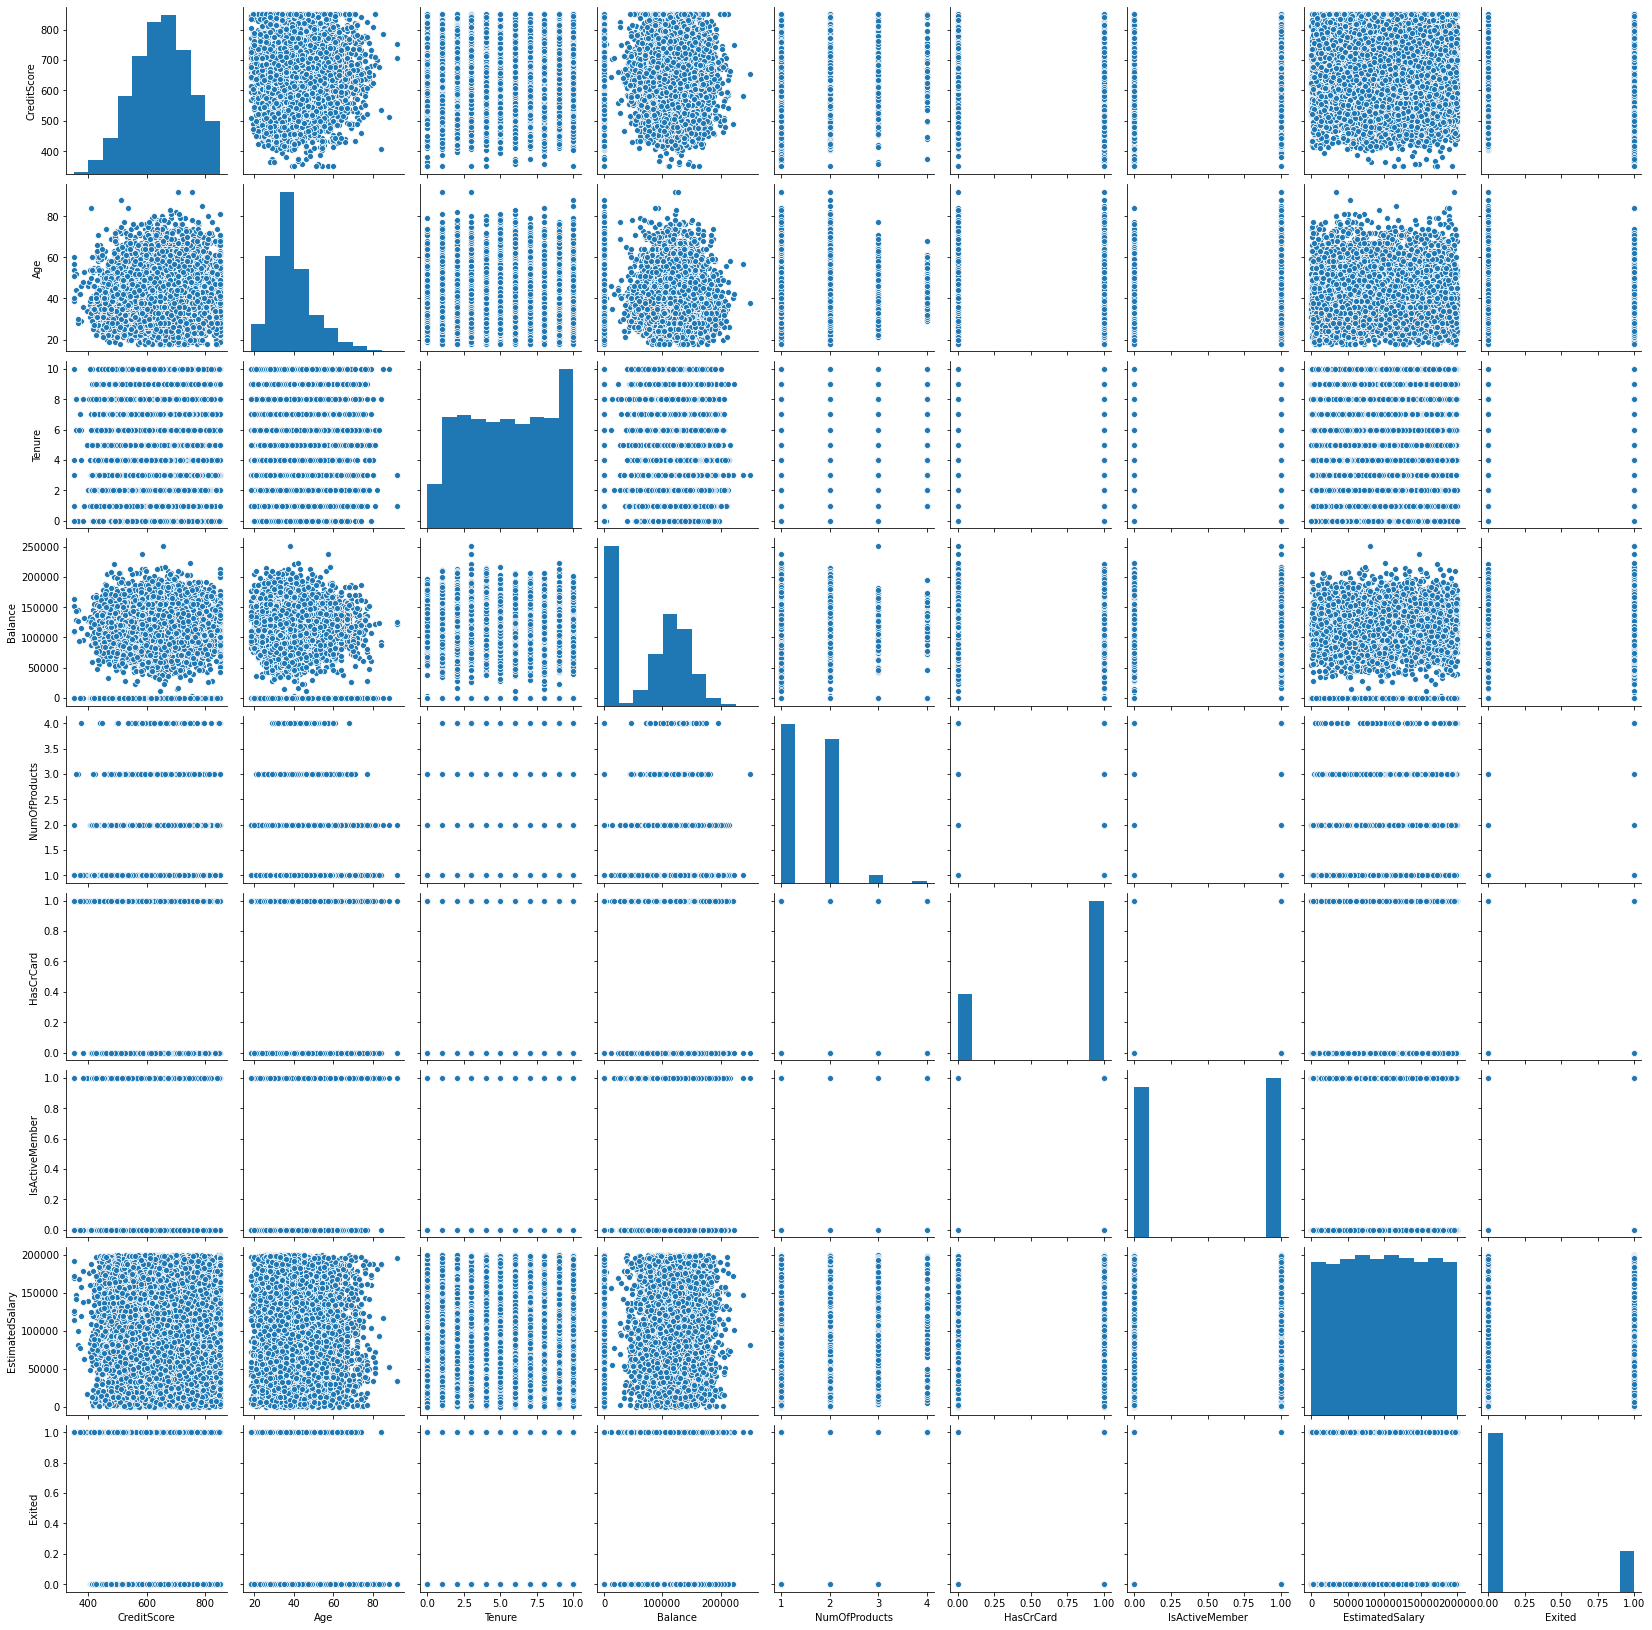

In [1054]:
sns.pairplot(df)

In [1067]:
#The distributions are not too skewed. The Balances seem to have a lot of values at the small end but it should not effect our modeling too much.
#The bivariate plots show almost no correlation between features which suggests independence.
#There seems to be a lot more 0s than 1s in our target value.

In [1068]:
target = df['Exited']
target.value_counts()
#More than 3 times as many false than true. I will run my model and if it is inaccurate I will correct this.

0    7963
1    2037
Name: Exited, dtype: int64

In [1069]:
df.corr() #does not seem to be any high correlation between features.

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
CreditScore,1.000000,-0.003965,0.000842,0.006268,0.012238,-0.005458,0.025651,-0.001384,-0.027094
Age,-0.003965,1.000000,-0.009997,0.028308,-0.030680,-0.011721,0.085472,-0.007201,0.285323
Tenure,0.000842,-0.009997,1.000000,-0.012254,0.013444,0.022583,-0.028362,0.007784,-0.014001
Balance,0.006268,0.028308,-0.012254,1.000000,-0.304180,-0.014858,-0.010084,0.012797,0.118533
NumOfProducts,0.012238,-0.030680,0.013444,-0.304180,1.000000,0.003183,0.009612,0.014204,-0.047820
HasCrCard,-0.005458,-0.011721,0.022583,-0.014858,0.003183,1.000000,-0.011866,-0.009933,-0.007138
IsActiveMember,0.025651,0.085472,-0.028362,-0.010084,0.009612,-0.011866,1.000000,-0.011421,-0.156128
EstimatedSalary,-0.001384,-0.007201,0.007784,0.012797,0.014204,-0.009933,-0.011421,1.000000,0.012097
Exited,-0.027094,0.285323,-0.014001,0.118533,-0.047820,-0.007138,-0.156128,0.012097,1.000000


In [1070]:
df.rename({'Geography': 'Origin', 'Gender': 'Male'}, axis=1,inplace=True) #Renaming columns to begin to deal with qualitative data

In [1071]:
print(df['Origin'].value_counts())
df['Origin'] = df['Origin'].map(lambda x: {'France': 1, 'Germany': 2, 'Spain': 3}.get(x))
df = pd.get_dummies(df, columns = ['Origin'])
df.drop('Origin_3', inplace=True, axis=1) #repeating dimension as only 2/3 are needed
#Dealt with origin of member through one-hot-encoding

France     5014
Germany    2509
Spain      2477
Name: Origin, dtype: int64


In [1072]:
df

,CreditScore,Male,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Origin_1,Origin_2
0,619,Female,42,2,0.00,1,1,1,101348.88,1,1,0
1,608,Female,41,1,83807.86,1,0,1,112542.58,0,0,0
2,502,Female,42,8,159660.80,3,1,0,113931.57,1,1,0
3,699,Female,39,1,0.00,2,0,0,93826.63,0,1,0
4,850,Female,43,2,125510.82,1,1,1,79084.10,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
9995,771,Male,39,5,0.00,2,1,0,96270.64,0,1,0
9996,516,Male,35,10,57369.61,1,1,1,101699.77,0,1,0
9997,709,Female,36,7,0.00,1,0,1,42085.58,1,1,0
9998,772,Male,42,3,75075.31,2,1,0,92888.52,1,0,1


In [1073]:
print(df['Male'].value_counts())
df['Male'] = df['Male'].map(lambda x: {'Female': 0, 'Male': 1}.get(x))

Male      5457
Female    4543
Name: Male, dtype: int64


In [1076]:
#split data into train and test sets
X = df.drop('Exited', axis=1)
y = df['Exited']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

y_train =  np.array(y_train)
y_test =  np.array(y_test)


In [1483]:
from sklearn.preprocessing import StandardScaler

# Define the scaler 
scaler = StandardScaler().fit(X_train)

# Scale the train set
X_train = scaler.transform(X_train)

# Scale the test set
X_test = scaler.transform(X_test)

In [1755]:
#Time for learning.

ncols = X_train.shape[0]
model = Sequential()

#layers
model.add(Dense(input_dim = 11, units=6, activation='relu', kernel_initializer='normal')) #Hidden layer 1
model.add(Dense(20, activation='relu', kernel_initializer='normal')) #Hidden layer 2
model.add(Dense(30, activation='relu', kernel_initializer='normal')) #Hidden layer 2
#model.add(Dense(20, activation='sigmoid', kernel_initializer='normal')) #Hidden layer 2
model.add(Dense(10, activation='sigmoid', kernel_initializer='normal')) #Hidden layer 3
model.add(Dense(2, activation='sigmoid', kernel_initializer='normal')) #Hidden layer 3
model.add(Dense(1)) #Output layer

#Optimizer
learning_rate = .01
optimizer = tf.keras.optimizers.Adam(learning_rate)

loss = 'binary_crossentropy'
#loss = 'mse'
model.compile(loss= loss, optimizer=optimizer , metrics = ['accuracy']) #giving class weights to deal with imbalance in data.
                   

epochs = 100


In [1756]:
history = model.fit(X_train, y_train, epochs=epochs, validation_split = 0.3, verbose = False, class_weight={1:1.3,0:.7})

hist  = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
print(hist)

        loss  accuracy  val_loss  val_accuracy  epoch
0   4.182365  0.791429  3.165787      0.794762      0
1   4.182366  0.791429  3.165787      0.794762      1
2   4.182363  0.791429  3.165787      0.794762      2
3   4.182364  0.791429  3.165787      0.794762      3
4   4.182364  0.791429  3.165787      0.794762      4
..       ...       ...       ...           ...    ...
95  4.182365  0.791429  3.165787      0.794762     95
96  4.182365  0.791429  3.165787      0.794762     96
97  4.182364  0.791429  3.165787      0.794762     97
98  4.182364  0.791429  3.165787      0.794762     98
99  4.182364  0.791429  3.165787      0.794762     99

[100 rows x 5 columns]


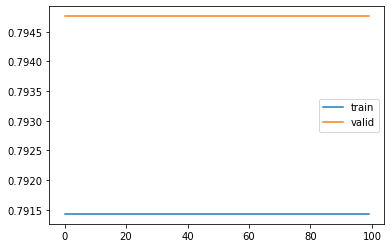

In [1757]:
plt.plot(hist['accuracy'])
plt.plot(hist['val_accuracy'])
plt.legend(("train" , "valid") , loc =0)


In [1758]:
#There seem to be spikes in my validation loss. I beleive this is caused because of the imbalance in the data.
#After multiple training and tweaking I found that 20 epochs lead to the right amount of learning without overfitting.

In [1759]:
#plt.plot(hist['Recall'])
#plt.plot(hist['val_Recall'])
#plt.legend(("train" , "valid") , loc =0)

In [1760]:
#There seem to be spikes in my validation loss. I beleive this is caused because of the imbalance in the data.
#After multiple training and tweaking I found that 20 epochs lead to the right amount of learning without overfitting.

In [1761]:
loss = model.evaluate(X_test, y_test, verbose=True)
y_pred = np.round(model.predict(X_test)) #convert to 0 or 1 by rounding the output. This is a .5 threshold. 
pd.Series(list(y_pred)).value_counts()


94/94 [==============================] - 0s 727us/step - loss: 3.0027 - accuracy: 0.8053


[-0.0]    3000
dtype: int64

In [1762]:
pd.Series(list(y_test)).value_counts()

0    2416
1     584
dtype: int64

In [1763]:
cf = pd.DataFrame(confusion_matrix(list(y_test),list(y_pred)))

In [1764]:
cf

,0,1
0,2416,0
1,584,0


In [1765]:
#Confusion Matrix.

In [1766]:
tn, fp, fn, tp = confusion_matrix(list(y_test),list(y_pred)).ravel()
print('Accuracy: {acc}, Recall: {rec}, Precision: {pre}'.format(acc = ((tn+tp)/(tn+fp+fn+tp)), rec = (tp/(tp+fn)), pre = (tp/(tp+fp))))

Accuracy: 0.8053333333333333, Recall: 0.0, Precision: nan


<ipython-input-1766-01415fb0aa6b>:2: RuntimeWarning: invalid value encountered in long_scalars
  print('Accuracy: {acc}, Recall: {rec}, Precision: {pre}'.format(acc = ((tn+tp)/(tn+fp+fn+tp)), rec = (tp/(tp+fn)), pre = (tp/(tp+fp))))


In [1767]:
#The model has high accuracy yet recall and precission are a bit low. I believe this is because of the imbalance in the data.
#To solve this issue we coul undersample the majority data (1) or resample using SMOTE the minority class (1).